In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
import scipy
import poppy
from skimage.draw import draw

# import personal code
from model_kit import datafiles as dfx
from model_kit import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

### Open the original data

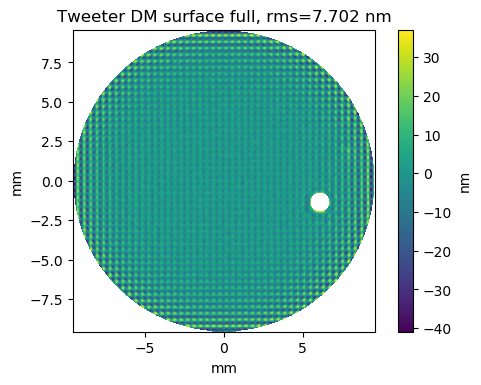

In [2]:
# Zygo data
twdm_raw = fits.open('magaox_2K_best_full_flat_zygo.fits')[0].data * u.micron
twdm_raw = twdm_raw.to(u.nm)
twdm_pixscl = (0.03182 * u.mm).to(u.m)#/u.pix

# rescale the bump to fit with the tweeter
# bump information based from vAPP plane
vapp_bump_diam = (0.5742*u.mm).to(u.m)
vapp_bump_radius = vapp_bump_diam/2
mag_relay = 0.513/1.0716 # f_oap4/f_oap3
tw_bump_radius = vapp_bump_radius/mag_relay

# make the mask
twdm_mask = np.zeros_like(twdm_raw.value)
cen = int(twdm_mask.shape[0]/2)
yy, xx = np.mgrid[-cen:cen, -cen:cen]
mask_radius = 301 # based on twdm_raw shortest side
twdm_mask = (yy**2 + xx**2 <= mask_radius**2)
bump_radius_pix = np.round(tw_bump_radius/twdm_pixscl).astype(int)
mark_coord = draw.circle(r=272, c=506, # identified by ds9
                         radius=bump_radius_pix) # bad actuator, size match
twdm_mask[mark_coord] = 0 #np.nan

# tighten the data
twdm_surf, twdm_mask = dfx.mat_tight(data=twdm_raw.value, mask=twdm_mask)

# aply mask to twdm
twdm = twdm_surf*twdm_raw.unit*twdm_mask

# calculate rms
twdm_rms = rms(twdm[twdm_mask==1])

# show surface
dfx.show_image(data=dfx.sn_map((twdm.to(u.nm)).value, twdm_mask),
               data_unit=u.nm,
               pixscale=(twdm_pixscl).to(u.mm),
               fig_title='Tweeter DM surface full, rms={0:.3f}'.format(twdm_rms))

### Interpolate the mask and surface with griddata

In [3]:
twdm.shape

(603, 603)

CPU times: user 8.92 s, sys: 324 ms, total: 9.25 s
Wall time: 9.02 s


Text(0.5, 1.0, 'mask interpolated')

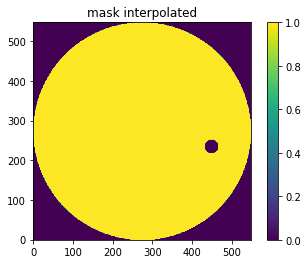

In [4]:
%%time
# build the coordinate points for the original data
d_twdm = twdm.shape[0]*twdm_pixscl
r_twdm = d_twdm/2
oy, ox = np.mgrid[-r_twdm.value:r_twdm.value:603j,
                  -r_twdm.value:r_twdm.value:603j]
orig_y = np.reshape(np.flipud(oy), np.product(oy.shape))
orig_x = np.reshape(ox, np.product(ox.shape))
    
# build the grids for the poppy scale
pixscl = 3.504185301e-05*u.m # pre-calculated from poppy
zoom_scl = (twdm_pixscl.value/pixscl.value)
new_npix = np.ceil(zoom_scl*twdm.shape[0]).astype(int)
npix_half = int(new_npix/2)
ny, nx = np.mgrid[-npix_half:npix_half,
                  -npix_half:npix_half]
new_y = np.flipud(ny)*pixscl
new_x = nx*pixscl

# Interpolate the mask
lin_mask = np.reshape(twdm_mask, np.product(twdm_mask.shape))
interp_mask = scipy.interpolate.griddata((orig_y,orig_x), lin_mask, (new_y, new_x),
                                         method='linear', fill_value=0.0)

plt.imshow(interp_mask, origin='lower')
plt.colorbar()
plt.title('mask interpolated')

CPU times: user 1.91 s, sys: 12.1 ms, total: 1.92 s
Wall time: 1.57 s


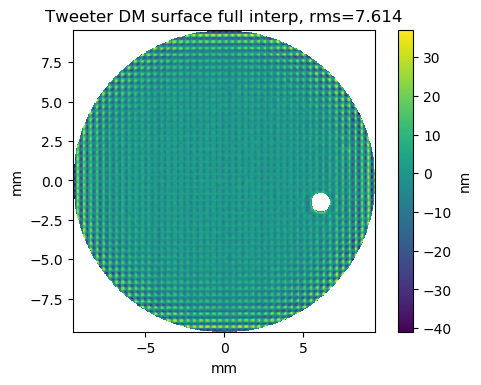

In [5]:
%%time
# interpolate the data
lin_twdm = np.reshape(twdm.value, np.product(twdm.shape))
interp_twdm = scipy.interpolate.griddata((orig_y,orig_x), lin_twdm, (new_y, new_x),
                                         method='nearest', fill_value=0.0)

# calculate rms
twdm_rms_cubic = rms(interp_twdm[interp_mask==1])

# show surface
dfx.show_image(data=dfx.sn_map(interp_twdm, interp_mask),
               data_unit=twdm.unit,
               pixscale=(pixscl).to(u.mm),
               fig_title='Tweeter DM surface full interp, rms={0:.3f}'.format(twdm_rms_cubic))

In [6]:
np.amax(twdm.value*twdm_mask)

37.07079516525413

In [7]:
np.amax(interp_twdm*interp_mask)

36.028007111306714

In [8]:
np.amin(twdm.value)

-40.90804966870576

In [9]:
np.amin(interp_twdm)

-40.90804966870576

### Crop, rotate, save final version

Text(0.5, 1.0, 'pupil mask (flip for parity)')

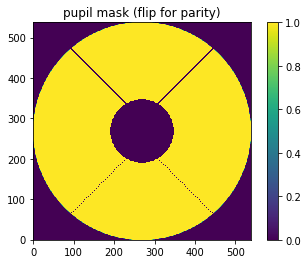

In [10]:
# build the pupil mask
samp = 538 # new number
pupil_mask = mf.mag_pupil_mask(samp=samp, entrance_radius=3.25*u.m,
                               wavelength=632*u.nm)
# adjust the mask for the tweeter plane
pupil_mask = np.flipud(np.fliplr(pupil_mask)) # oh parity...

plt.imshow(pupil_mask, origin='lower')
plt.colorbar()
plt.title('pupil mask (flip for parity)')

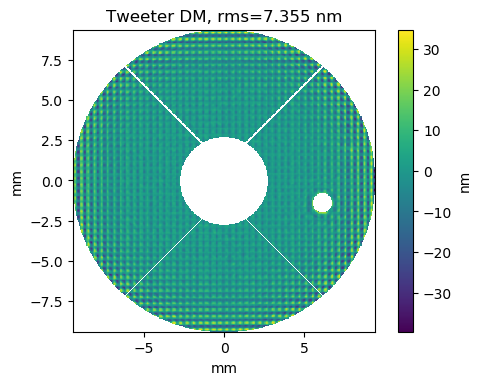

In [11]:
# crop the data down for POPPY sizes
mask_prerot = poppy.utils.pad_or_crop_to_shape(interp_mask, (samp, samp))
mask_prerot *= pupil_mask
dm_prerot = poppy.utils.pad_or_crop_to_shape(interp_twdm, (samp, samp))

rms_prerot = rms(dm_prerot[mask_prerot==1])*twdm.unit

# show surface
dfx.show_image(data=dfx.sn_map(dm_prerot, mask_prerot*pupil_mask),
               data_unit=twdm.unit,
               pixscale=(pixscl).to(u.mm),
               fig_title='Tweeter DM, rms={0:.3f}'.format(rms_prerot))

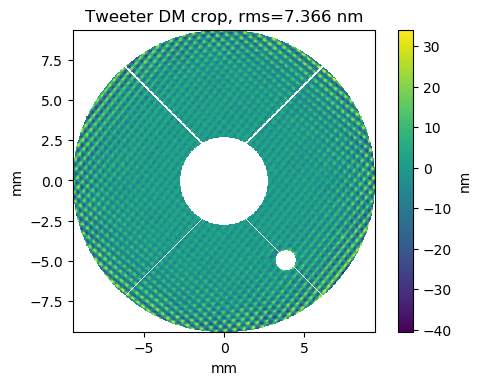

In [30]:
# Rotate the data (iterative process)
rot_ang = 39
rot_dm = scipy.ndimage.rotate(dm_prerot, rot_ang, reshape=False)

# rotation doesn't hold well with mask, so need to check coordinates in ds9
#fits.writeto('twdm_rot_{0}_{1}.fits'.format(rot_ang, samp), rot_dm, overwrite=True

# generate only the bump region
act_obs = mf.gen_mag_bump(entrance_radius=3.25*u.m, samp=samp)
wf = poppy.poppy_core.Wavefront(npix=samp, diam=3.25*u.m*2, wavelength=632e-9*u.m)
act_mask = act_obs.get_transmission(wf)
act_mask = np.flipud(np.fliplr(act_mask))

# set the pupil
pupil_mask_bump = pupil_mask * act_mask

# calculate rms
bump_rms = rms(rot_dm[pupil_mask_bump==1]) * twdm.unit

# show surface
dfx.show_image(data=dfx.sn_map(rot_dm, pupil_mask_bump),
               data_unit=twdm.unit,
               pixscale=(pixscl).to(u.mm),
               fig_title='Tweeter DM crop, rms={0:.3f}'.format(bump_rms))

In [33]:
# save the opd with angle and without the pupil mask
refl_ang = 11.716*u.deg
opd = (rot_dm * act_mask * 2 * twdm_raw.unit / np.cos(refl_ang)).to(u.m)

# fits header file
hdr = fits.Header()
hdr['puplscal'] = (pixscl.value, 'pixel scale [m/pix]')
hdr['bunit'] = (str(opd.unit), 'OPD units')
hdr['rot_ang'] = (rot_ang, 'rotation angle [deg]')
hdr['act_x'] = (379, 'actuator center, x-axis [pix]')
hdr['act_y'] = (128, 'actuator center, y-axis [pix]')
hdr['act_rad'] = (18, 'actuator radius [pix]')
hdr['refl_ang'] = (refl_ang.value, 'reflection angle [deg]')
fits.writeto('tweeter_meters_opd_{0}.fits'.format(samp),
             opd.value, hdr, overwrite=True)

### How does the surface rms look like with the vapp masked on top?

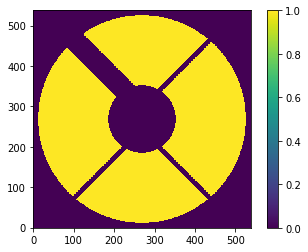

In [35]:
# open up the vapp mask
home_dir = '/home/jhen/XWCL/code/MagAOX/'
vapp_dir = home_dir + 'data/coronagraph/'
vapp_mask_loc = vapp_dir + 'vAPP_trans_2PSF_538_4x_656nm.fits'
vapp_mask = fits.open(vapp_mask_loc)[0].data
plt.imshow(vapp_mask, origin='lower')
plt.colorbar()

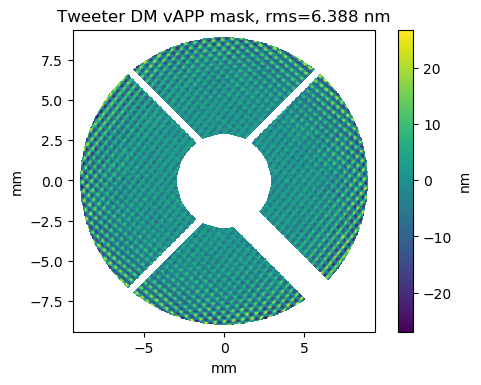

In [36]:
# flip mask around to accomodate tweeter parity
vapp_mask = np.flipud(np.fliplr(vapp_mask))

# calculate rms with the vapp mask
vapp_rms = rms(rot_dm[vapp_mask==1]) * twdm.unit

# show surface
dfx.show_image(data=dfx.sn_map(rot_dm, vapp_mask),
               data_unit=twdm.unit,
               pixscale=(pixscl).to(u.mm),
               fig_title='Tweeter DM vAPP mask, rms={0:.3f}'.format(vapp_rms))

In [37]:
# check rms with angle component
vapp_rms/np.cos(11.716*u.deg)

<Quantity 6.52383744 nm>

### Reference

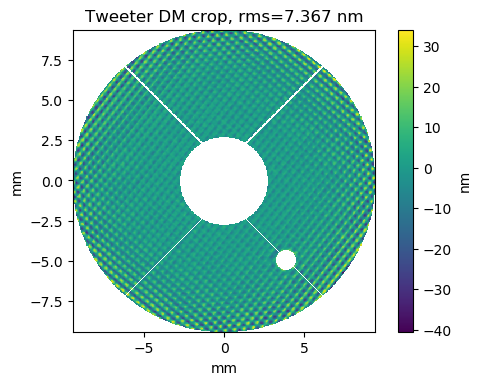

In [22]:
# Visual check for bump mask r,c coordinates
# changes slightly when placing on the M1 pixelscale, but close enough.

# mask the bump
bump_mask = np.ones_like(rot_dm)
bcen = int(bump_mask.shape[0]/2)
by, bx = np.mgrid[-bcen:bcen, -bcen:bcen]
b_radius_pix = tw_bump_radius.value/pixscl.value
#b_radius = np.round(bump_radius.value/pixscl.value).astype(int)
br = 128
bc = 379
b_coord = draw.circle(r=br, c=bc, radius=np.ceil(b_radius_pix).astype(int))
bump_mask[b_coord] = 0 #np.nan
tw_bump = bump_mask*pupil_mask

# calculate rms
bump_rms = rms(rot_dm[tw_bump==1]) * twdm.unit

# show surface
dfx.show_image(data=dfx.sn_map(rot_dm, tw_bump),
               data_unit=twdm.unit,
               pixscale=(pixscl).to(u.mm),
               fig_title='Tweeter DM crop, rms={0:.3f}'.format(bump_rms))